In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Path to uploaded dataset in Kaggle input directory
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# Clean column names
df.columns = df.columns.str.strip()

# Check existence of target column
if "Humanitarian_Class" not in df.columns:
    raise KeyError("Column 'Humanitarian_Class' not found in the dataset. Please check the column names.")

# Stratified splitting (70% train, 15% val, 15% test)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["Humanitarian_Class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["Humanitarian_Class"], random_state=42)

# Output directory (Kaggle writable location)
output_dir = "/kaggle/working"
train_df.to_csv(os.path.join(output_dir, "train_data.csv"), index=False)
val_df.to_csv(os.path.join(output_dir, "val_data.csv"), index=False)
test_df.to_csv(os.path.join(output_dir, "test_data.csv"), index=False)

# Summary of splits
split_summary = pd.DataFrame({
    "Train (70%)": train_df["Humanitarian_Class"].value_counts(),
    "Validation (15%)": val_df["Humanitarian_Class"].value_counts(),
    "Test (15%)": test_df["Humanitarian_Class"].value_counts(),
    "Total": df["Humanitarian_Class"].value_counts()
}).T

split_summary.to_csv(os.path.join(output_dir, "split_summary.csv"))

print("✅ Dataset successfully split and saved to '/kaggle/working'.")


✅ Dataset successfully split and saved to '/kaggle/working'.


2025-04-13 11:05:47.327398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744542347.572999      87 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744542347.640780      87 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744542365.234057      87 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/d

Epoch 1/30


I0000 00:00:1744542371.246510     145 service.cc:148] XLA service 0x7c4238027ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744542371.247353     145 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744542371.653860     145 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744542374.416835     145 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


285/285 - 11s - 40ms/step - accuracy: 0.5152 - loss: 2.1430 - val_accuracy: 0.1983 - val_loss: 2.7523
Epoch 2/30
285/285 - 1s - 2ms/step - accuracy: 0.7191 - loss: 1.4488 - val_accuracy: 0.1950 - val_loss: 2.4054
Epoch 3/30
285/285 - 1s - 2ms/step - accuracy: 0.7644 - loss: 1.1969 - val_accuracy: 0.5894 - val_loss: 1.4991
Epoch 4/30
285/285 - 1s - 2ms/step - accuracy: 0.7880 - loss: 1.0616 - val_accuracy: 0.6903 - val_loss: 1.2406
Epoch 5/30
285/285 - 1s - 2ms/step - accuracy: 0.8022 - loss: 1.0018 - val_accuracy: 0.7246 - val_loss: 1.1348
Epoch 6/30
285/285 - 1s - 2ms/step - accuracy: 0.8123 - loss: 0.9579 - val_accuracy: 0.7953 - val_loss: 1.0309
Epoch 7/30
285/285 - 1s - 2ms/step - accuracy: 0.8163 - loss: 0.9425 - val_accuracy: 0.8554 - val_loss: 0.8814
Epoch 8/30
285/285 - 1s - 3ms/step - accuracy: 0.8217 - loss: 0.9198 - val_accuracy: 0.8525 - val_loss: 0.8608
Epoch 9/30
285/285 - 1s - 2ms/step - accuracy: 0.8198 - loss: 0.9203 - val_accuracy: 0.7380 - val_loss: 1.1034
Epoch 10/3

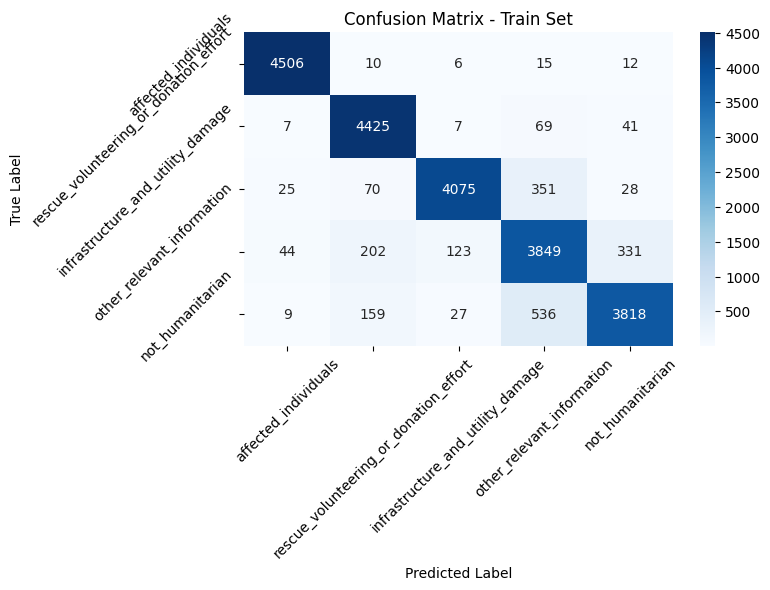

In [2]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.constraints import MaxNorm
import os

# Set paths to dataset files uploaded to Kaggle (adjust these as needed)
input_path = "/kaggle/working"  # Replace with your dataset folder name
train_path = os.path.join(input_path, "train_data.csv")
val_path = os.path.join(input_path, "val_data.csv")  # Optional
test_path = os.path.join(input_path, "test_data.csv")

# Load datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Normalize column names
for df in [train_df, test_df]:
    df.columns = df.columns.str.strip().str.lower()

# Define label mapping
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}

# Clean and preprocess labels
y_train = train_df['humanitarian_class'].fillna('not_humanitarian').str.strip().str.lower().map(label_map).astype(int)
y_test = test_df['humanitarian_class'].fillna('not_humanitarian').str.strip().str.lower().map(label_map).astype(int)

# Fill missing values
train_df['processed_data'] = train_df['processed_data'].fillna("")
test_df['processed_data'] = test_df['processed_data'].fillna("")

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df['processed_data'])
X_test = vectorizer.transform(test_df['processed_data'])

# Handcrafted features
for df in [train_df, test_df]:
    df['tweet_length'] = df['processed_data'].apply(len)
    df['num_hashtags'] = df['processed_data'].apply(lambda x: x.count("#"))
    df['num_mentions'] = df['processed_data'].apply(lambda x: x.count("@"))

scaler = StandardScaler()
X_train_features = scaler.fit_transform(train_df[['tweet_length', 'num_hashtags', 'num_mentions']])
X_test_features = scaler.transform(test_df[['tweet_length', 'num_hashtags', 'num_mentions']])

# Combine features
X_train_combined = np.hstack((X_train.toarray(), X_train_features))
X_test_combined = np.hstack((X_test.toarray(), X_test_features))

# SMOTE for balancing
max_class_samples = max(Counter(y_train).values())
sampling_strategy = {label: max_class_samples for label in np.unique(y_train)}
smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=3, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_combined, y_train)

# Convert labels to categorical for Keras
y_train_cat = to_categorical(y_train_balanced, num_classes=5)

# Build CNN model with increased regularization, batch normalization, and smaller architecture
model = Sequential()
model.add(Dense(64, input_shape=(X_train_balanced.shape[1],), activation='relu', kernel_regularizer=l2(0.01), kernel_constraint=MaxNorm(3)))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Lower dropout rate
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01), kernel_constraint=MaxNorm(3)))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Lower dropout rate
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01), kernel_constraint=MaxNorm(3)))
model.add(BatchNormalization())
model.add(Dropout(0.2))  # Lower dropout rate
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping with validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with validation data to prevent overfitting
model.fit(X_train_balanced, y_train_cat, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stopping], verbose=2)

# Evaluate on Train Set
y_train_proba = model.predict(X_train_balanced)
y_train_pred = np.argmax(y_train_proba, axis=1)

# Classification Report and Accuracy
print("Train Classification Report:\n", classification_report(y_train_balanced, y_train_pred, target_names=label_map.keys()))
print("Train Accuracy:", accuracy_score(y_train_balanced, y_train_pred))

# Confusion Matrix
cm = confusion_matrix(y_train_balanced, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Train Set")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
